In this example, we will use Pyreal's decision tree explainer to find the top contributing features in the Student Performance dataset.

Data source:

P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.


In [1]:
### Imports
import pandas as pd
import numpy as np
import sys

First, we load in the data, and provide human-readable descriptions of every feature. These descriptions will make the resulting explanations much more user friendly.

In [2]:
feature_descriptions = {
    "school":"School",
    "sex":"Sex",
    "age":"Age",
    "address":"Address type",
    "famsize":"Family size",
    "Pstatus":"Parent's cohibition status",
    "Medu":"Mother's education",
    "Fedu":"Father's education",
    "Mjob":"Mother's job",
    "Fjob":"Father's job",
    "reason":"Reason for choosing this school",
    "guardian":"Student's guardian",
    "traveltime":"Home to school travel time",
    "studytime":"Weekly study time",
    "failures":"Number of past class failures",
    "schoolsup":"Extra education support",
    "famsup":"Family eductional support",
    "paid":"Extra paid classes within the subject",
    "activities":"Extra-curricular activities",
    "nursery":"Attended nursery school",
    "higher":"Wants to take higher education",
    "internet":"Has internet at home",
    "romantic":"In a romantic relationship",
    "famrel":"Quality of family relationships (1-5)",
    "freetime":"Amount of free time after school (1-5)",
    "goout":"Frequency of going out with friends (1-5)",
    "Dalc":"Frequency of workday alcohol consumption (1-5)",
    "Walc":"Frequency of workday alcohol consumption (1-5)",
    "health":"Current health status (1-5)",
    "absences":"Number of school absences"
}

file_path = "student-por.csv"
data_table = pd.read_csv(file_path, sep=";")

Next, we extract our chosen target variable. In this case, we will be predicting whether a student will pass (score > 10).

In [3]:
y = (data_table["G3"]>10).astype(int)

data = data_table.drop(["G1", "G2","G3"], axis='columns')
X = data

Now, we will create the transformers. The first will encode boolean features as integers, the second will one hot encode categorical features, and the first with standardize the data.

Some transformation and explanation type combos require post-hoc transformations on the explanations themselves. In this case, we will run SHAP on the one-hot-encoded features, and then recombine the contributions of these features. The OneHotEncoderWrapper includes this functionality.

In [4]:
from pyreal.transformers import Transformer, OneHotEncoder, DataFrameWrapper
from sklearn.preprocessing import StandardScaler

class BooleanEncoder(Transformer):
    def __init__(self, cols, **kwargs):
        self.cols = cols
        super().__init__(**kwargs)

    def data_transform(self, x):
        x_transform = x.copy()
        for col in self.cols:
            x_transform[col].replace(('yes', 'no'), (1, 0), inplace=True)
        x_transform["famsize"] = x_transform["famsize"].astype('category')
        x_transform["famsize"].cat.set_categories(['LE3', 'GT3'], inplace=True)
        x_transform["famsize"].cat.reorder_categories(['LE3', 'GT3'], inplace=True)
        x_transform["famsize"] = x_transform["famsize"].cat.codes
        return x_transform

    def inverse_transform_explanation(self, explanation):
        return explanation

onehotencoder = OneHotEncoder(["school", "sex", "address", "Pstatus", "reason", "guardian", "Mjob", "Fjob"],
                              model=True)
boolean_encoder = BooleanEncoder(["schoolsup", "famsup", "paid", "activities", "nursery", "internet", "romantic", "higher"],
                                 model=True)
standard_scaler = DataFrameWrapper(StandardScaler(), model=True)

Now, we can create the DecisionTreeExplainer object, using the information generated above.
Our transformers are currently not fit to data, so we can have our Explainer fit them using the
`fit_transformers` parameter.

In [5]:
from pyreal.explainers import DecisionTreeExplainer

transformers = [onehotencoder, boolean_encoder, standard_scaler]
dte = DecisionTreeExplainer(model="model.pkl",
                            x_train_orig=X, is_classifier=True, max_depth=5,
                            transformers=transformers,
                            feature_descriptions=feature_descriptions,
                            fit_transformers=True)

Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For mo

We can test the accuracy of the model

In [6]:
preds = dte.model_predict(X)
print("Accuracy: %.2f%%" % (np.mean(preds==y)*100))

Accuracy: 81.97%


The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
X has feature names, but LogisticRegression was fitted without feature names


Finally, we fit our explainer, and take a look at the most predictive features.

In [7]:
dte.fit()

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
X has feature names, but LogisticRegression was fitted without feature names


We can visualize the explanation by plotting the explanation tree.

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


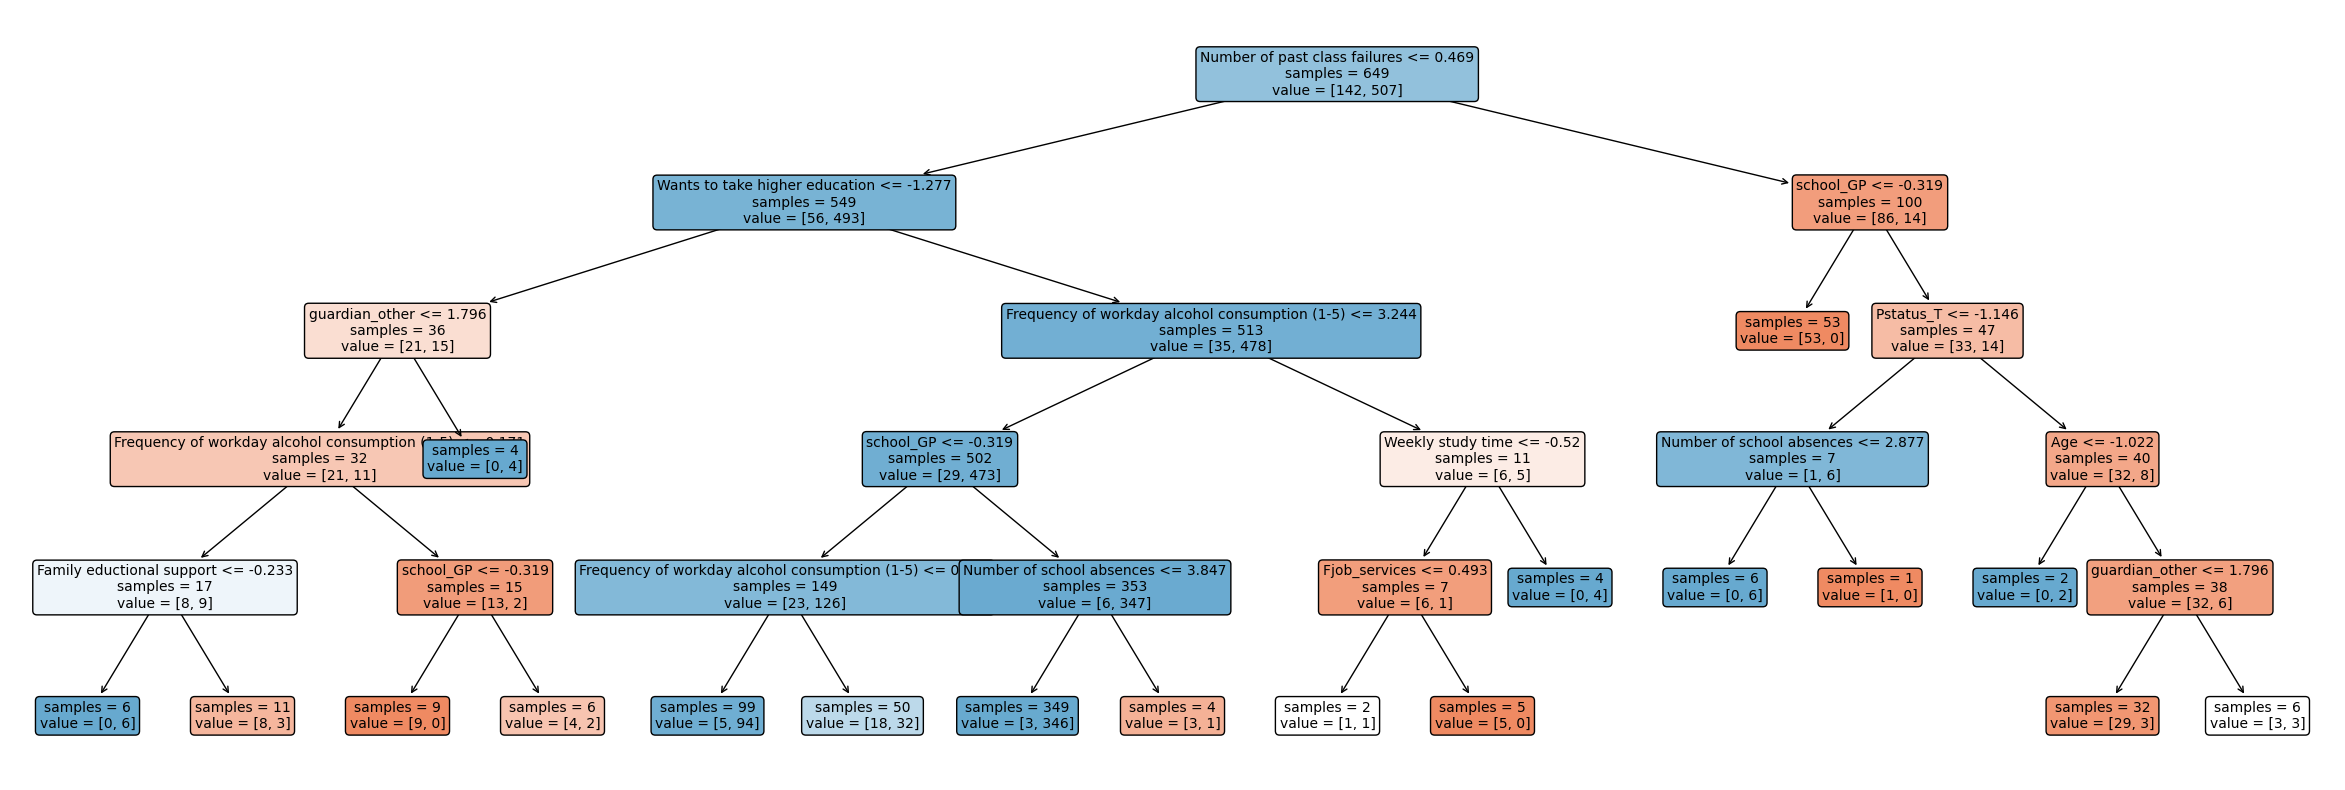

In [8]:
from pyreal.visualize import plot_tree_explanation

plot_tree_explanation(dte)

We can also plot the feature importances of the decision tree, which summarizes the overall importance of features across all inputs.

The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


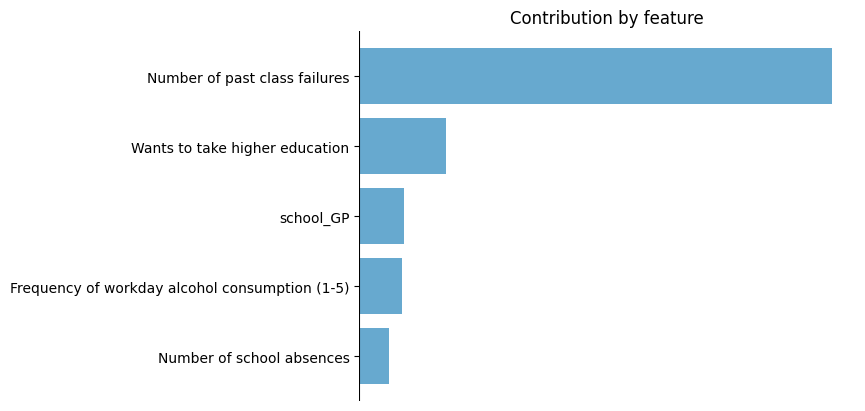

In [9]:
from pyreal import visualize

importances = dte.produce_importances()

visualize.plot_top_contributors(importances, select_by="absolute")
